# Exploratory Data Analysis

In [1]:
import pandas as pd
import psycopg2
import sqlalchemy
import matplotlib
from sqlalchemy import create_engine

Establish a connection with the database

In [2]:
# Postgres username, password, and database name
POSTGRES_ADDRESS = 'localhost' 
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'postgres' 
POSTGRES_PASSWORD = 'postgres' 
POSTGRES_DBNAME = 'greyhounds'

postgres_str = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"

# Create the connection
cnx = create_engine(postgres_str)

# Database Schema

Data from the greyhound-data website has been obtained and populated into a postgres database with the following schema

![title](https://github.com/tonyjward/dogs/blob/master/notebooks/images/database_schema.png)

In this notebook we'll explore some of the tables to get a feel for this data, and perform some data quality checks

# Stadiums
Although races take place across many race stadiums in the UK, we only gathered data for one stadium - Monmore

In [3]:
pd.read_sql_query('''
SELECT * from stadiums
''', cnx)

,stadium_id,stadium_name
0,13037,Monmore


# Races
Data is available for 54 thousand races that took place between January 2002 and June 2020

In [4]:
pd.read_sql_query('''
SELECT count(*) as race_count, min(date_time) as earliest_race, max(date_time) as last_race
FROM races
''', cnx)

,race_count,earliest_race,last_race
0,54224,2002-01-03 18:09:00+00:00,2020-06-30 16:54:00+00:00


# Race Information
A typical race contains several pieces of information. An example race is provided below

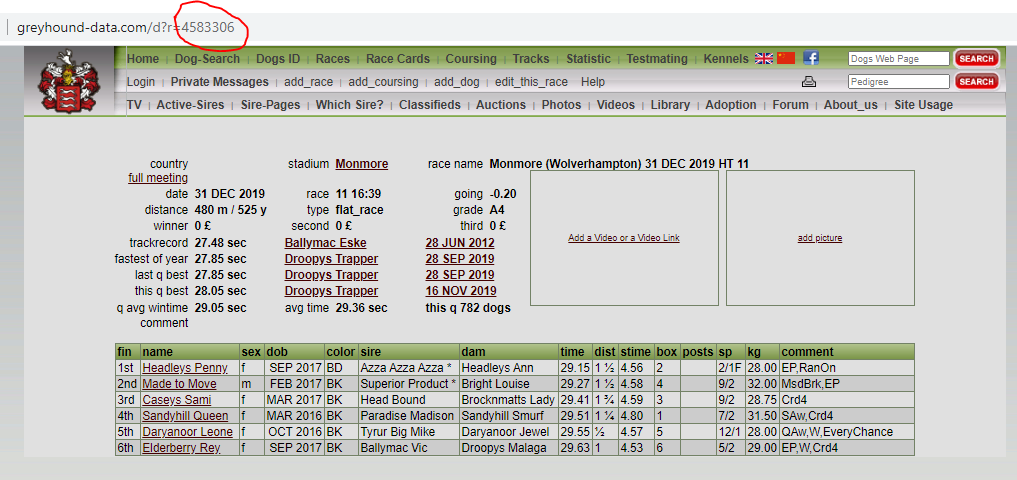

The URL contains a unique identifier which we call race_id. The race_id is the primary key in both the races and positions tables. We can reconstruct the above table using the following query (note that due to time constraints we did not capture the sex, dob, color, sire, dam information)

In [5]:
pd.read_sql_query('''
SELECT p.fin, d.dog_name, p.time, p.dist, p.stime, p.box, p.sp, p.kg, p.comment, 
r.race_name, r.race_no, r.date_time, r.going, r.grade, r.distance
FROM positions p
LEFT JOIN races r ON
    r.race_id = p.race_id
LEFT JOIN dogs d ON
    d.dog_id = p.dog_id
WHERE p.race_id = 4583306
ORDER by p.fin''', cnx)

,fin,dog_name,time,dist,stime,box,sp,kg,comment,race_name,race_no,date_time,going,grade,distance
0,1,Headleys Penny,29.15,1 ½,4.56,2,2/1F,28.00,"ep,ranon",Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y
1,2,Made to Move,29.27,1 ½,4.58,4,9/2,32.00,"msdbrk,ep",Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y
2,3,Caseys Sami,29.41,1 ¾,4.59,3,9/2,28.75,crd4,Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y
3,4,Sandyhill Queen,29.51,1 ¼,4.80,1,7/2,31.50,"saw,crd4",Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y
4,5,Daryanoor Leone,29.55,½,4.57,5,12/1,28.00,"qaw,w,everychance",Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y
5,6,Elderberry Rey,29.63,1,4.53,6,5/2,29.00,"ep,w,crd4",Monmore (Wolverhampton) 31 DEC 2019 HT 11,11,2019-12-31 16:39:00+00:00,-0.20,A4,480 m / 525 y


## Distance
Dogs race over a range of distances. 

<AxesSubplot:xlabel='distance'>

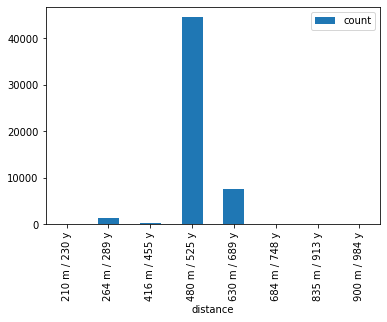

In [6]:
distance = pd.read_sql_query('''
SELECT distance, count(*)
FROM races
GROUP BY distance
ORDER BY distance
''', cnx, index_col = 'distance')
distance.plot(kind = 'bar')

For simplicity we will restrict ourselves to the most frequently occurring race distance

# Grade
Races are organised in such a way so that dogs of similar ability race each other. The most competitive grade that has the fastest dogs are Open Races (OR). In these races dogs travel across the country and race against dogs from different stadiums. Grades A1 to A10 are local races where the dogs will race at the same stadium each week. A1 has the fastest dogs and A10 the slowest. Dogs are moved up and down a grade at the discretion of the race director based on recent form. A dog is automatically moved up a grade if it wins a race, and moves down a grade if it fails to place (finish in the top 3) for three races in a row

<AxesSubplot:xlabel='grade'>

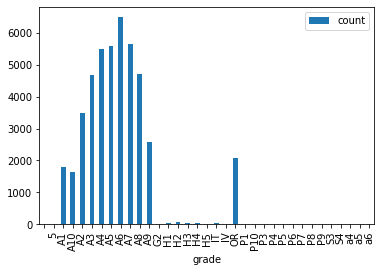

In [7]:
grade = pd.read_sql_query('''
SELECT grade, count(*)
FROM races
WHERE distance = '480 m / 525 y'
GROUP BY grade
ORDER BY grade

''', cnx, index_col = 'grade')
grade.plot(kind = 'bar')


The class of the race also determines the distance - D are shorter sprints, S are longer races with A races in the middle. OR are open races and these take place over a variety of distances. Since we have restricted ourselves to 480m races that is why we only see A class races

# Time

In [8]:
pd.read_sql_query('''
SELECT p.*, r.distance
FROM positions p
LEFT JOIN races r ON
    p.race_id = r.race_id
WHERE p.time IS NOT NULL and r.distance = '480 m / 525 y'
ORDER BY time
limit 10''', cnx)

,position_id,race_id,dog_id,fin,time,dist,stime,box,posts,sp,kg,comment,distance
0,23056,970811,340131,4,20.58,,4.58,3,,5/1,,"quickly away, crowded first a",480 m / 525 y
1,6738,3208063,1863989,1,27.48,,4.27,1,,1/5F,,"Ran&FinWll,(TkRec)",480 m / 525 y
2,120418,2751412,1647401,1,27.60,,4.15,2,1111,5/4,,"qaw, midtorls, (trackrecord)",480 m / 525 y
3,67655,4175158,2146615,1,27.63,,4.34,3,,5/4F,35.00,SoonLed,480 m / 525 y
4,211107,3806756,1994675,1,27.70,,4.21,6,,4/7F,32.25,"qaw,wide,drewclear",480 m / 525 y
5,95263,2720253,1489722,1,27.71,,4.08,3,1111,7/4,,"quickaway, (trackrecord)",480 m / 525 y
6,167836,3212881,1863989,1,27.71,,4.30,1,,2/7F,,"ep,ran&finwell",480 m / 525 y
7,38522,3033044,1717609,1,27.74,,4.28,3,,4/5F,,SoonLed,480 m / 525 y
8,259670,3576671,1994675,1,27.74,,4.24,6,,1/1F,,"qaw,w,soonled",480 m / 525 y
9,284673,2589596,1535955,1,27.76,,4.13,2,4221,4/6F,,"msdbrk, ep, (trackrecord)",480 m / 525 y


Looking at the race with this quickest time (race_id = 970811) http://www.greyhound-data.com/d?r=970811 We can see that the dog finished first in 29.12 however the dog that finished fourth finished in 20.58 which is clearly an error


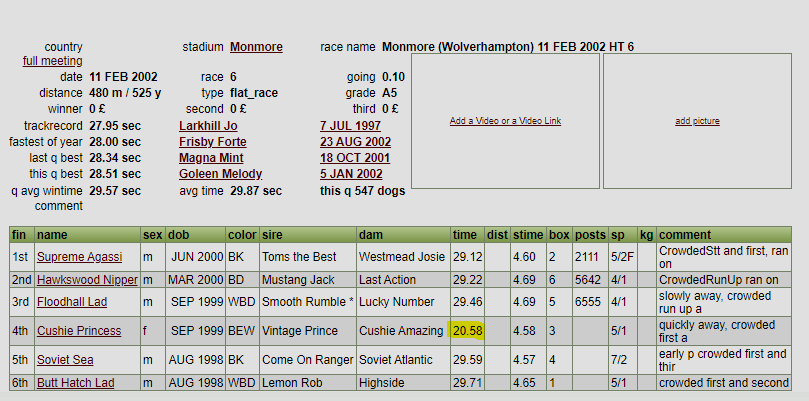

In [9]:
pd.read_sql_query('''
SELECT p.*, r.distance
FROM positions p
LEFT JOIN races r ON
    p.race_id = r.race_id
WHERE p.time IS NOT NULL and r.distance = '480 m / 525 y'
ORDER BY time desc
limit 10''', cnx)

,position_id,race_id,dog_id,fin,time,dist,stime,box,posts,sp,kg,comment,distance
0,299530,3095859,1609597,6,101.35,8 ½,None,1,,6/1,,,480 m / 525 y
1,228998,3084516,1746667,6,101.12,4,None,3,,7/4F,,,480 m / 525 y
2,317069,3105206,1600169,6,101.09,4 ½,None,1,,10/1,,,480 m / 525 y
3,317103,3105211,1675189,6,100.93,3,None,5,,10/1,,,480 m / 525 y
4,229030,3084521,1423132,6,100.91,HD,None,5,,5/2,,,480 m / 525 y
5,229026,3084521,1617492,5,100.89,4,None,1,,5/1,,,480 m / 525 y
6,229418,3079698,1804723,6,100.83,2,None,4,,4/1,,,480 m / 525 y
7,228996,3084516,1675038,5,100.80,NK,None,1,,5/1,,,480 m / 525 y
8,228999,3084516,1804242,4,100.77,2 ¾,None,4,,9/2,,,480 m / 525 y
9,45448,1248731,958881,6,100.74,1 ¾,None,1,,7/2,,,480 m / 525 y


There looks to be something strange going on with the slowest times. If we inspect the race with the slowest times 3091058 http://www.greyhound-data.com/d?r=3091058 we can see that the first dog recorded a time of 99.99 and the rest of the times are in italics

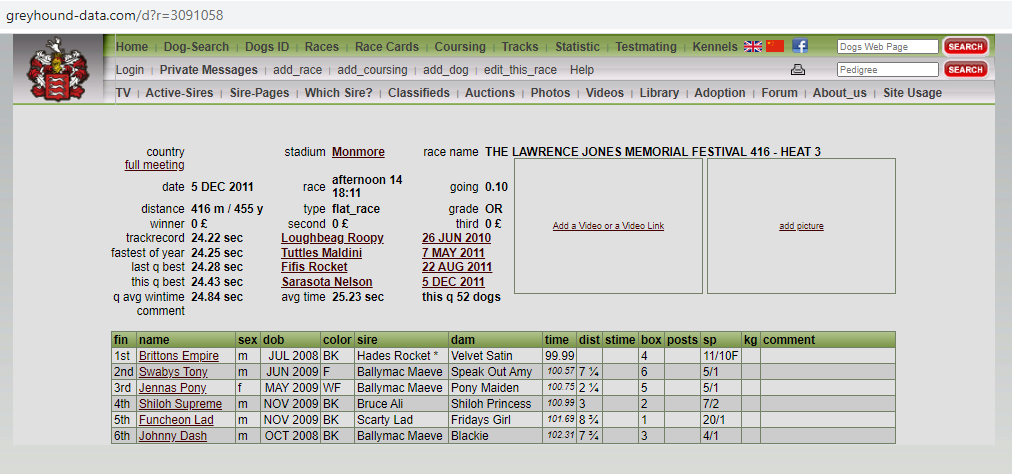

Clicking on the dog "Brittons Empire" that won the race we can see the history of its past races. This dog typically completes the race in under 30 seconds, and the 99.99 must be a data quality issue

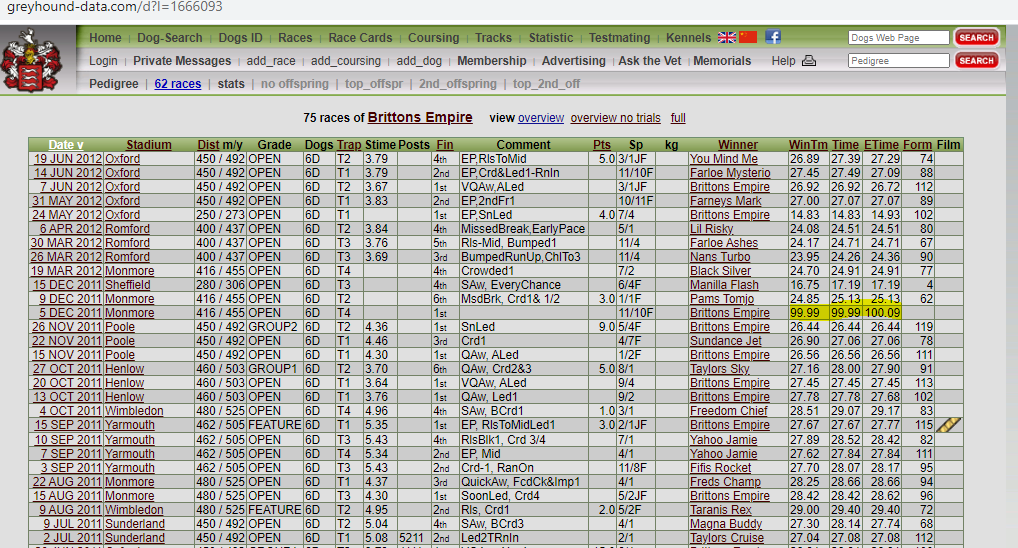

To quantify the problem we'll do a histogram of all the times for a given race distance

In [10]:
mid_distance_races = pd.read_sql_query('''
SELECT p.*, r.distance
FROM positions p
LEFT JOIN races r ON
    p.race_id = r.race_id
WHERE p.time IS NOT NULL and r.distance = '480 m / 525 y'
''', cnx)
mid_distance_races

,position_id,race_id,dog_id,fin,time,dist,stime,box,posts,sp,kg,comment,distance
0,1,2539775,1079143,3,29.35,4,4.39,1,,4/1,,EveryChance,480 m / 525 y
1,2,2539775,1403952,5,29.58,¾,4.25,2,3123,9/4F,,Crowded1&2,480 m / 525 y
2,3,2539775,1373611,1,28.87,,4.32,3,5532,3/1,,"MsdBrk, EP, Crd2, RanOn",480 m / 525 y
3,4,2539775,1372869,6,29.61,NK,4.26,4,1255,6/1,,"QAw, Crowded1&2",480 m / 525 y
4,5,2851623,1696719,3,29.97,6,4.53,1,2333,8/1,,impeded1,480 m / 525 y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262379,323292,2539774,1453245,5,29.40,1 ¾,4.46,2,5555,6/1,,crowdedrunup,480 m / 525 y
262380,323293,2539774,1315009,6,29.53,1 ¾,4.45,3,6666,9/4F,,crdrunup&1,480 m / 525 y
262381,323294,2539774,1355146,3,29.20,¾,4.33,4,3133,7/2,,crowdedrunup&1,480 m / 525 y
262382,323295,2539774,1355514,2,29.14,2,4.32,5,2211,7/1,,"epace, crd1&4",480 m / 525 y


<AxesSubplot:ylabel='Frequency'>

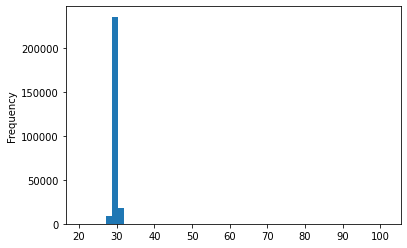

In [14]:
mid_distance_races['time'].plot.hist(bins = 50)

In [12]:
mid_distance_races[['time', 'stime']].describe([0.0001,0.001, 0.01, .25, .5, .75, 0.99, 0.999, 0.9999])

,time,stime
count,262384.000000,260999.000000
mean,29.571383,4.497702
std,2.227873,1.138436
min,20.580000,0.400000
0.01%,27.840000,3.210000
0.1%,28.100000,4.100000
1%,28.430000,4.190000
25%,29.160000,4.380000
50%,29.480000,4.470000
75%,29.820000,4.550000


Having inspected the percentiles we decide to remove any race from the data the contains times outside the following ranges
* 26 < time < 40
* 3 < stime < 6
